## Figures for analysis of combined dataset
This notebook reproduces Figures 1A, 1D-E, S1B


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd
import re
import numpy as np
import glob
from pathlib import Path
from scipy import sparse
from copy import deepcopy
import pickle


<h3> Load data </h3>

In [3]:
out_dir = '/data/peer/chanj3/HTA.combined.010920/out.publication.010920/'

In [4]:
adata = sc.read(out_dir + 'adata.combined.mnnc.010920.h5ad')


Only considering the two last: ['.010920', '.h5ad'].
Only considering the two last: ['.010920', '.h5ad'].


<h3> Figure 1A </h3>

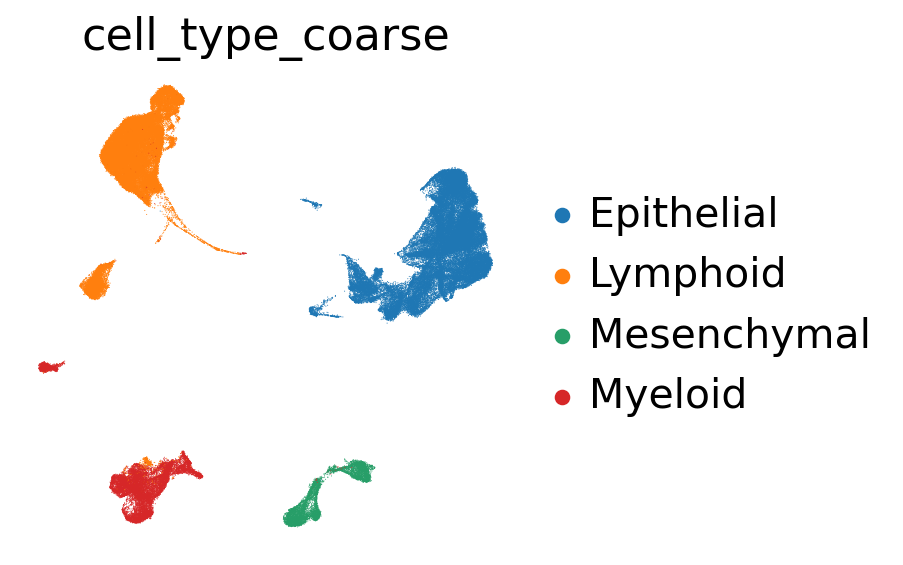

In [24]:
plt.rcParams['figure.figsize'] = (5,5)
sc.set_figure_params(fontsize=20)

sc.pl.umap(
    adata,
    color=['cell_type_coarse'],
    frameon=False, use_raw = False,
    sort_order=False, 
    ncols=1, 
)

<h3> Figure 1D </h3>

In [4]:
def entropy(labels):
    value,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()
    return -(norm_counts * np.log2(norm_counts)).sum()

In [5]:
ct_dir = [
    '/home/chanj3/calcifer/SCLC_atlas/version.010920/publication.010920/out.SCLC.010920/adata.SCLC.010920.h5ad',
    '/home/chanj3/calcifer/SCLC_atlas/version.010920/publication.010920/out.NSCLC_epithelial.010920/adata.NSCLC_epithelial.010920.h5ad',
    '/home/chanj3/calcifer/SCLC_atlas/version.010920/publication.010920/out.mesenchymal.010920/adata.mesenchymal.010920.h5ad',    
    '/home/chanj3/calcifer/SCLC_atlas/version.010920/publication.010920/out.immune.010920/adata.immune.010920.h5ad',
]

In [6]:
adata_tmp = sc.read_h5ad('/home/chanj3/calcifer/SCLC_atlas/version.010920/publication.010920/out.NSCLC_epithelial.010920/adata.NSCLC_epithelial.010920.h5ad')

In [7]:
tx_df = adata_tmp.obs.loc[:,['batch', 'treatment']]
tx_df = tx_df.loc[~tx_df.duplicated(),:]

In [8]:
ct_dict = {}

for fn in ct_dir:
    ct = os.path.basename(fn).split('.')[1]
    adata_ct = sc.read_h5ad(fn)
    if ct!='SCLC':
        key = 'cell_type'
    else:
        key = 'SCLC_subtype'
    ct_dict[ct] = adata_ct.obs.loc[:,key]

In [9]:
cell_type = []
for ct in ct_dict.keys():
    cell_type.append(ct_dict[ct])
cell_type = pd.concat(cell_type, axis=0)


In [10]:
cell_type = cell_type.str.replace('NK|T cells|B cell|Plasma cell','Lymphoid')
cell_type = cell_type.str.replace('Mast|Erythrocyte','Myeloid')
cell_type = cell_type.str.replace('Tuft|AE1|AEP|Club|Ciliated|Mucinous|Ionocyte|Hepatocyte|Basal|Neuroendocrine','Epithelial')

In [11]:
#Extract fine clusters (Leiden clustering within each cell type subset at fine resolution = 2 without log transform 
#to ensure comparability across cell types)
clusters_ct = {}
for fn in ct_dir:
    ct = os.path.basename(fn).split('.')[1]
    print(ct)
    adata_ct = sc.read_h5ad(fn)
    if ct=='NSCLC_epithelial':
        ind1 = adata_ct.obs.cell_type == 'NSCLC'
        ind2 = adata_ct.obs.histo=='SCLC'
        exclude_cells = adata_ct.obs.index[ind1.values & ind2.values] 
        adata_ct = adata_ct[adata_ct.obs.index.difference(exclude_cells),:] #Removing possible NSCLC from combined histology
    clusters_ct[ct] = adata_ct.obs.loc[:, 
                                       ['clusters_fine','patient','histo']].rename(columns={'clusters_fine':'clusters'})



SCLC
NSCLC_epithelial
mesenchymal
immune


In [12]:
H_null = []
for ct in clusters_ct.keys():
    clusters_df = clusters_ct[ct]
        
    for i in set(clusters_df.clusters):
        cells = clusters_df.index[clusters_df.clusters == i]
        ct_fine = cell_type.loc[cells]
        
        Hs = []
        for x in range(100):
            cells_rand = cells[np.random.choice(len(cells),100)]              
            Hs.append(entropy(clusters_df.loc[cells_rand,'patient'].values)) 

        tmp = pd.DataFrame({'Entropy': Hs,
                            'Fine Cell Type': ct_fine.value_counts().index[0],
                           })            

        H_null.append( tmp )
                                  
H_null = pd.concat(H_null, axis=0)    


In [13]:
H_mean = H_null.loc[:,['Entropy','Fine Cell Type']].groupby(['Fine Cell Type']).apply(lambda x: x.mean())
H_mean = H_mean.sort_values('Entropy')

In [55]:
H_mean

,Entropy
Fine Cell Type,
SCLC-P,0.401958
SCLC-N,0.483686
SCLC-A,0.744923
NSCLC,1.033813
Fibroblast,1.897049
Endothelial,2.197386
Epithelial,2.334971
Lymphoid,2.955851
Myeloid,2.977225


In [14]:
from scipy.stats import ttest_ind

In [15]:
cancer_types = ['SCLC-P','SCLC-N','SCLC-A','NSCLC']

In [16]:
ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type'].isin(cancer_types),'Entropy'], 
          H_null.loc[~H_null.loc[:,'Fine Cell Type'].isin(cancer_types),'Entropy'])

Ttest_indResult(statistic=-96.53018938020786, pvalue=0.0)

In [57]:
pval_mat = pd.DataFrame(0, index=H_mean.index, columns = H_mean.index)
num_comparisons = len(H_mean)*(len(H_mean)-1)/2
for i in H_mean.index:
    for j in H_mean.index:
        pval_mat.loc[i,j] = min(1,ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type']==i,'Entropy'], 
                                            H_null.loc[H_null.loc[:,'Fine Cell Type']==j,'Entropy'])[1]*num_comparisons)

In [58]:
pval_mat.index.name = ''
pval_mat.columns.name = ''


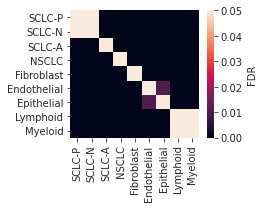

In [28]:
ax = plt.subplots(1,1,figsize=(3.7,3))
sns.heatmap(data = pval_mat, vmin=0, vmax=0.05, cbar_kws={'label': 'FDR'})
plt.tight_layout()

In [29]:
sns.set_style('ticks')

In [71]:
{(H_mean.index[i],H_mean.index[i+1]): min(1,
                                          ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type']==H_mean.index[i],'Entropy'], 
                                                    H_null.loc[H_null.loc[:,'Fine Cell Type']==H_mean.index[i+1],'Entropy'])[1]*(len(H_mean)-1)) for i in range(len(H_mean)-1)}

{('SCLC-P', 'SCLC-N'): 0.9018681868183775,
 ('SCLC-N', 'SCLC-A'): 5.7376998610002625e-18,
 ('SCLC-A', 'NSCLC'): 6.207773447880802e-16,
 ('NSCLC', 'Fibroblast'): 3.5390956901160682e-96,
 ('Fibroblast', 'Endothelial'): 0.00011246486259152375,
 ('Endothelial', 'Epithelial'): 1.4951414796123363e-09,
 ('Epithelial', 'Lymphoid'): 2.993040741219719e-137,
 ('Lymphoid', 'Myeloid'): 1}

/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


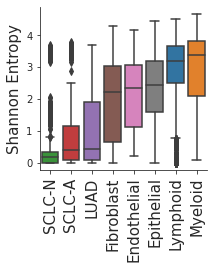

In [59]:
plt.figure(figsize = (3,3))
pal = np.array(sns.color_palette('tab10'))
pal = np.concatenate([pal[2:-2,:], pal[:2,:]], axis=0)

H_null2 = H_null.loc[H_null.loc[:,'Fine Cell Type']!='SCLC-P',:]
H_null2.loc[:,'Fine Cell Type'] = H_null2.loc[:,'Fine Cell Type'].astype(str).str.replace('NSCLC','LUAD').astype('category')
ax = sns.boxplot(x='Fine Cell Type',y='Entropy', data = H_null2,
                 order= list(H_null2.groupby('Fine Cell Type').mean().sort_values('Entropy').index),
                  palette = pal)
ax.set_ylabel('Shannon Entropy', fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize=15)
sns.despine(ax=ax)


<h3> Figure 1E </h3>

In [17]:
ct_dict = {}

for fn in ct_dir:
    ct = os.path.basename(fn).split('.')[1]
    adata_ct = sc.read_h5ad(fn)
    if ct!='SCLC':
        key = 'cell_type'
    else:
        key = 'SCLC_subtype'
    ct_dict[ct] = adata_ct.obs.loc[adata_ct.obs.treatment == 'Naive',key]

In [18]:
cell_type = []
for ct in ct_dict.keys():
    cell_type.append(ct_dict[ct])
cell_type = pd.concat(cell_type, axis=0)


In [19]:
cell_type = cell_type.str.replace('NK|T cells|B cell|Plasma cell','Lymphoid')
cell_type = cell_type.str.replace('Mast|Erythrocyte','Myeloid')
cell_type = cell_type.str.replace('Tuft|AE1|AEP|Club|Ciliated|Mucinous|Ionocyte|Hepatocyte|Basal|Neuroendocrine','Epithelial')

In [20]:
#Extract fine clusters (Leiden clustering within each cell type subset at fine resolution = 2 without log transform 
#to ensure comparability across cell types)
clusters_ct = {}
for fn in ct_dir:
    ct = os.path.basename(fn).split('.')[1]
    print(ct)
    adata_ct = sc.read_h5ad(fn)
    if ct=='NSCLC_epithelial':
        ind1 = adata_ct.obs.cell_type == 'NSCLC'
        ind2 = adata_ct.obs.histo=='SCLC'
        exclude_cells = adata_ct.obs.index[ind1.values & ind2.values] 
        adata_ct = adata_ct[adata_ct.obs.index.difference(exclude_cells),:] #Removing possible NSCLC from combined histology
    tmp = adata_ct.obs.loc[adata_ct.obs.treatment=='Naive', 
                                       ['clusters_fine','patient','histo']].rename(columns={'clusters_fine':'clusters'})
    
    tally = tmp.clusters.value_counts()
    tmp = tmp.loc[tmp.clusters.isin(tally.index[tally > 30]), :]
    print('\t%d' % sum(tally > 30))
    clusters_ct[ct] = tmp

SCLC
	21
NSCLC_epithelial
	25
mesenchymal
	34
immune
	50


In [21]:
H_null = []
for ct in clusters_ct.keys():
    clusters_df = clusters_ct[ct]
        
    for i in set(clusters_df.clusters):
        cells = clusters_df.index[clusters_df.clusters == i]
        ct_fine = cell_type.loc[cells]
        
        Hs = []
        for x in range(100):
            cells_rand = cells[np.random.choice(len(cells),100)]              
            Hs.append(entropy(clusters_df.loc[cells_rand,'patient'].values)) 

        tmp = pd.DataFrame({'Entropy': Hs,
                            'Fine Cell Type': ct_fine.value_counts().index[0],
                           })            

        H_null.append( tmp )
                                  
H_null = pd.concat(H_null, axis=0)    


In [22]:
H_mean = H_null.loc[:,['Entropy','Fine Cell Type']].groupby(['Fine Cell Type']).apply(lambda x: x.mean())
H_mean = H_mean.sort_values('Entropy')

In [23]:
H_mean

,Entropy
Fine Cell Type,
SCLC-N,0.420725
SCLC-A,1.246686
NSCLC,1.497651
Fibroblast,1.616735
Endothelial,1.745757
Epithelial,2.263260
Myeloid,2.309631
Lymphoid,2.681216


In [24]:
from scipy.stats import ttest_ind

In [25]:
cancer_types = ['SCLC-P','SCLC-N','SCLC-A','NSCLC']

In [26]:
ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type'].isin(cancer_types),'Entropy'], 
          H_null.loc[~H_null.loc[:,'Fine Cell Type'].isin(cancer_types),'Entropy'])

Ttest_indResult(statistic=-56.28750871475538, pvalue=0.0)

In [40]:
cancer_types = ['SCLC-P','SCLC-N','SCLC-A','NSCLC']

ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type'].isin(cancer_types),'Entropy'], 
          H_null.loc[~H_null.loc[:,'Fine Cell Type'].isin(cancer_types),'Entropy'])pval_mat = pd.DataFrame(0, index=H_mean.index, columns = H_mean.index)
num_comparisons = len(H_mean)*(len(H_mean)-1)/2
for i in H_mean.index:
    for j in H_mean.index:
        pval_mat.loc[i,j] = min(1,ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type']==i,'Entropy'], 
                                            H_null.loc[H_null.loc[:,'Fine Cell Type']==j,'Entropy'])[1]*num_comparisons)

In [41]:
pval_mat.index.name = ''
pval_mat.columns.name = ''


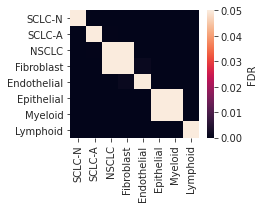

In [83]:
ax = plt.subplots(1,1,figsize=(3.7,3))
sns.heatmap(data = pval_mat, vmin=0, vmax=0.05, cbar_kws={'label': 'FDR'})
plt.tight_layout()

In [42]:
sns.set_style('ticks')

In [85]:
{(H_mean.index[i],H_mean.index[i+1]): min(1,
                                          ttest_ind(H_null.loc[H_null.loc[:,'Fine Cell Type']==H_mean.index[i],'Entropy'], 
                                                    H_null.loc[H_null.loc[:,'Fine Cell Type']==H_mean.index[i+1],'Entropy'])[1]*(len(H_mean)-1)) for i in range(len(H_mean)-1)}

{('SCLC-N', 'SCLC-A'): 3.0958762517554966e-69,
 ('SCLC-A', 'NSCLC'): 4.908743509172606e-05,
 ('NSCLC', 'Fibroblast'): 0.34290775480608543,
 ('Fibroblast', 'Endothelial'): 0.00032736221246314526,
 ('Endothelial', 'Epithelial'): 4.0498245973078864e-83,
 ('Epithelial', 'Myeloid'): 1,
 ('Myeloid', 'Lymphoid'): 7.936243857635003e-62}

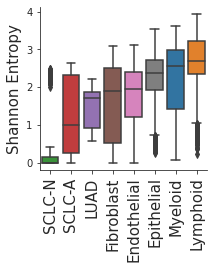

In [44]:
plt.figure(figsize = (3,3))
pal = np.array(sns.color_palette('tab10'))
pal = np.concatenate([pal[2:-2,:], pal[:2,:]], axis=0)

H_null2 = H_null.loc[H_null.loc[:,'Fine Cell Type']!='SCLC-P',:]
H_null2.loc[:,'Fine Cell Type'] = H_null2.loc[:,'Fine Cell Type'].astype(str).str.replace('NSCLC','LUAD').astype('category')
ax = sns.boxplot(x='Fine Cell Type',y='Entropy', data = H_null2,
                 order= list(H_null2.groupby('Fine Cell Type').mean().sort_values('Entropy').index),
                  palette = pal)
ax.set_ylabel('Shannon Entropy', fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize=15)
sns.despine(ax=ax)



<h3> Figure S1B </h3>

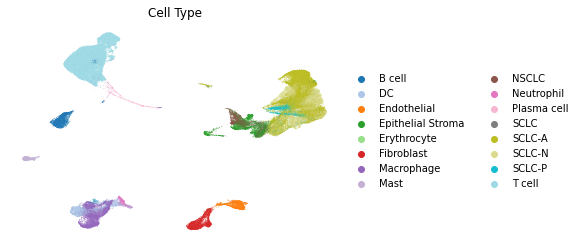

In [9]:
sc.pl.umap(
adata,
color=['cell_type_med'],
    palette='tab20',
frameon=False, s=1,
sort_order=False,title='Cell Type',
ncols=2)

In [11]:
######################
'''
ENTROPY
'''
from scipy.stats import entropy
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import find, csr_matrix

pca_merge = pd.DataFrame(adata.obsm['X_pca'],
                         index = adata.obs.index)

# Nearest neighbor graph construction and affinity matrix
print('Nearest neighbor computation...')
n_neighbors = 30
nbrs = NearestNeighbors(n_neighbors=n_neighbors,
                        metric='euclidean', n_jobs=-2)
nbrs.fit(pca_merge.values)
adj = nbrs.kneighbors_graph(pca_merge.values, mode='distance')

patient = adata.obs.patient

H_knn = pd.Series(index = patient.index)
for i in range(adj.shape[0]):
    knn = adj[i,:]
    x,y,d = find(knn)
    H_knn.iloc[i] = entropy(patient[y].value_counts())
adata.obs['H_knn'] = H_knn.loc[adata.obs_names]

Nearest neighbor computation...


/home/chanj3/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


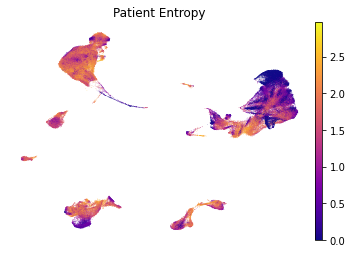

In [12]:
sc.pl.umap(
adata,
color=['H_knn'],
color_map='plasma',
frameon=False,
sort_order=False, title = 'Patient Entropy',
ncols=2)